In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import json
import os
import matplotlib as mpl
mpl.style.use("default")
from datetime import datetime
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt

from joblib import Parallel, delayed

import datetime
import sys
sys.path.insert(0, '/home/ubuntu/kolomeytsev/centurion/')
sys.path.insert(0, '/home/ubuntu/kolomeytsev/analytics/')
from common.exchanges.exchange_main import ExchangeDB
from common.etl.models import OHLCVCandle, Exchange, Instrument
from common.etl.helpers import ExtractorCandles, ExtractorOrderbooks, ExtractorTrades, Resolution

sys.path.insert(0, '/home/ubuntu/kolomeytsev/analytics/')
from utils.constants import *
from utils.utils_analytics import download_data_from_db


def transform_to_timestamp(datetime_time):
    return int(datetime.datetime.strptime(datetime_time, "%Y-%m-%d %H:%M:%S").timestamp())

def convert_to_panel(df, companies, features, start_ts=None, end_ts=None):
    all_dates = sorted(set(df["minor"]))
    all_dates = np.array(all_dates)
    if start_ts is not None:
        start = datetime.datetime.fromtimestamp(start_ts).strftime("%Y-%m-%d %H-%M-%S")
        all_dates = all_dates[all_dates > start]
    if end_ts is not None:
        end = datetime.datetime.fromtimestamp(end_ts).strftime("%Y-%m-%d %H-%M-%S")
        all_dates = all_dates[all_dates < end]
    time_index = pd.to_datetime(all_dates)
    panel = pd.Panel(items=features, major_axis=companies, minor_axis=time_index, dtype=np.float32)
    for company in companies:
        df_company = df[df["major"] == company]
        df_company = df_company.set_index(pd.to_datetime(df_company["minor"]))
        for feat in features:
            panel.loc[feat, company, time_index] = df_company.loc[time_index][feat]
    return panel

/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
features = ["close"]
companies = [
    "FEES", "PLZL", "LKOH", "ROSN", "GMKN", "POLY", 
    "MAGN", "RSTI", "MGNT", "ALRS", "MSNG", "NVTK", 
    "MVID", "HYDR", "RTKM", "MTLR", "VTBR", "PHOR", 
    "CHMF", "AFLT", "AFKS", "SNGS", "MTSS", "RASP", 
    "MFON", "NLMK", "TATN", "SBER", "GAZP", 
    "SIBN", "MOEX", "IRAO"
]

In [3]:
path_part = "/home/ubuntu/kolomeytsev/rl_server_moex/moex/data/with_splits/moex_close_2014_2019/"

In [4]:
ls "/home/ubuntu/kolomeytsev/rl_server_moex/moex/data/with_splits/moex_close_2014_2019/"

moex_close_2014_2019_hour_1.csv  moex_close_2014_2019_hour_8.csv
moex_close_2014_2019_hour_4.csv


In [5]:
def fix_split(df):
    df[df["major"] == "IRAO"]["close"].plot()
    close = df[df["major"] == "IRAO"]["close"]
    returns = close.values[1:] / close.values[:-1]
    index = np.argwhere(returns > 2)[0,0]
    split_coef = close.iloc[index + 1] / close.iloc[index]
    df.loc[close.iloc[:index + 1].index, "close"] *= split_coef
    df.loc[close.iloc[:index + 1].index, "high"] *= split_coef
    df.loc[close.iloc[:index + 2].index, "low"] *= split_coef

In [6]:
#path = "/home/ds/kolomeytsev/rl_server_moex/data/without_splits/moex_full_2014_2019_hour_1_additional_data.csv"
#df = pd.read_csv(path)
#fix_split(df)
#df[df["major"] == "IRAO"]["close"].plot()
#panel = convert_to_panel(df, companies, features)
#panel["close"].T.to_csv(path_part + "moex_close_2014_2019_hour_1.csv")
#panel["close"].T.isna().sum()

In [7]:
path_part = "/home/ubuntu/kolomeytsev/rl_server_moex/moex/data/with_splits/moex_close_2014_2019/"
df_close_hour_8 = pd.read_csv(path_part + "moex_close_2014_2019_hour_8.csv")

In [8]:
df_close_hour_8.shape

(2681, 33)

In [9]:
df_close_hour_8.iloc[-ticks_number:]

NameError: name 'ticks_number' is not defined

In [10]:
exchange = "moex_close_2014_2019_hour_8"

In [11]:
path_part = "../data/good_backtests/"
results = {}
lens_dict = {}
for x in os.listdir(path_part):
    path = path_part + x
    run_id = x.split(".")[0].split("_")[1]
    with open(path, "r") as f:
        res = json.load(f)
    if res["data_config"]["exchange"] != exchange:
        print(path)
    #if len(res["data_config"]["instruments_list"]) != 30:
    #    print(path, len(res["data_config"]["instruments_list"]))
    for agent_name, agents_results in res["agents"].items():
        results[agent_name + "_" + run_id] = agents_results
        lens_dict[agent_name + "_" + run_id] = len(agents_results["returns_no_fee"])

In [12]:
ticks_number = 2630

In [13]:
sorted(lens_dict.items(), key=lambda x: x[1])[0]

('trend_follow_73', 2638)

In [127]:
def get_normalized_data(results, ticks_number):
    """
    makes so, that every agents start at the same time
    time start is stated by ticks_number parameter from the end
    """
    normalized_results = {}
    for agent_name, agents_results in results.items():
        res_normed = {}
        for res_name, res in agents_results.items():
            if res_name != "config":
                res_normed[res_name] = np.array(res[-ticks_number:])
        res_normed["instruments_list"] = agents_results["config"]["instruments_list"] 
        normalized_results[agent_name] = res_normed
    return normalized_results

In [128]:
all_instruments = set()
for x, val in results.items():
    all_instruments |= set(val["config"]["instruments_list"])

In [129]:
json.dumps(list(all_instruments))

'["MTSS", "AFLT", "FEES", "PHOR", "GAZP", "RASP", "POLY", "ALRS", "ROSN", "MVID", "GMKN", "IRAO", "SNGS", "MAGN", "AFKS", "NVTK", "MOEX", "CHMF", "SIBN", "PLZL", "RSTI", "MGNT", "RTKM", "MFON", "TATN", "MSNG", "NLMK", "HYDR", "VTBR", "LKOH", "SBER"]'

In [130]:
results_normalized = get_normalized_data(results, ticks_number)

In [165]:
results_normalized["rmr_trend_follow_93"]["weights"][:, -1]

array([0., 0., 0., ..., 1., 0., 0.])

In [174]:
results["bmar2_top1_3_80"]["config"]["use_risk_free"], np.array(results["bmar2_top1_3_80"]["weights"]).shape

(True, (2672, 31))

In [175]:
results["trend_follow_6_113"]["config"]["use_risk_free"], np.array(results["trend_follow_6_113"]["weights"]).shape

(False, (2639, 31))

In [ ]:
trend_follow_6_113

In [230]:
results_normalized["bmar2_top1_3_80"]

{'returns_no_fee': array([1.00607602, 1.0027896 , 1.00038897, ..., 0.99773211, 1.00490104,
        0.99591121]),
 'returns_with_fee': array([1.00607602, 1.0027896 , 1.00038897, ..., 0.99773211, 1.00490104,
        0.99591121]),
 'turnover': array([2., 2., 2., ..., 2., 2., 2.]),
 'weights': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'epochs': array([  50,   51,   52, ..., 2677, 2678, 2679]),
 'instruments_list': ['FEES',
  'PLZL',
  'LKOH',
  'ROSN',
  'GMKN',
  'POLY',
  'MAGN',
  'RSTI',
  'MGNT',
  'ALRS',
  'MSNG',
  'NVTK',
  'MVID',
  'HYDR',
  'RTKM',
  'VTBR',
  'PHOR',
  'CHMF',
  'AFLT',
  'SNGS',
  'MTSS',
  'RASP',
  'MFON',
  'NLMK',
  'TATN',
  'SBER',
  'GAZP',
  'SIBN',
  'MOEX',
  'IRAO']}

In [231]:
results_normalized["bmar2_top1_3_80"]["returns_no_fee"].shape

(2630,)

In [233]:
results_normalized["bmar2_top1_3_80"]["weights"].shape

(2630, 31)

In [234]:
epochs_dict = {}
for x, y in results_normalized.items():
    epochs_dict[x] = y["epochs"]

In [235]:
for x, y in epochs_dict.items():
    if y[0] != 50 or y[-1] != 2679 or len(y) != 2630:
        print(x)

In [236]:
def compute_returns(results, fee, threshold_final_ret=1, 
                    threshold_sharpe=.8, is_cumulative=True, trades_per_day=2):
    best_results = {}
    for agent, res in results.items():
        weights = res["weights"][:,:-1]
        fee_values = res["turnover"] * fee
        ret_values = res["returns_no_fee"]
        ret_with_fee_by_step = ret_values - fee_values
        if is_cumulative:
            ret_with_fee = np.cumprod(ret_with_fee_by_step)
            ret_no_fee = np.cumprod(ret_values)
        else:
            ret_with_fee = np.cumsum(ret_with_fee_by_step - 1) + 1
            ret_no_fee = np.cumsum(ret_values - 1) + 1

        sharpe_with_fee = np.mean(ret_with_fee_by_step - 1) / \
                            np.std(ret_with_fee_by_step) * (252 * trades_per_day)**0.5
        sharpe_no_fee = np.mean(ret_values - 1) / \
                            np.std(ret_values) * (252 * trades_per_day)**0.5
        if sharpe_with_fee > threshold_sharpe and ret_with_fee[-1] > threshold_final_ret:
            best_results[agent] = {
                "ret_with_fee": ret_with_fee,
                "ret_no_fee": ret_no_fee,
                "sharpe_with_fee": sharpe_with_fee,
                "sharpe_no_fee": sharpe_no_fee,
                "weights": weights,
                "instruments_list": res["instruments_list"]
            }
        if agent == "crp_121":
            best_results[agent] = {
                "ret_with_fee": ret_with_fee,
                "ret_no_fee": ret_no_fee,
                "sharpe_with_fee": sharpe_with_fee,
                "sharpe_no_fee": sharpe_no_fee,
                "weights": weights,
                "instruments_list": res["instruments_list"]
            }
    return best_results

In [237]:
len(results_normalized)

157

In [238]:
best_results = compute_returns(results_normalized, 3e-4)

In [239]:
len(best_results)

43

In [240]:
best_results.keys()

dict_keys(['markowitz20_117', 'markowitz30_117', 'markowitz40_117', 'bmar1_3_top2_79', 'bmar1_3_top5_79', 'trend_follow_6_113', 'anticor_3_84', 'anticor_7_84', 'cfr_ogd3_107', 'cfr_ogd3_3_3_107', 'cfr_ons3_3_3_107', 'eg_98', 'bmar1_3_85', 'bmar1_5_85', 'bmar2_85', 'rmr_trend_follow_95', 'rmr_trend_follow_2_95', 'rmr_trend_follow_3_91', 'rmr_trend_follow_3_top3_91', 'arma_3_104', 'rmr_2_87', 'ons_top1_100', 'ons_top2_100', 'ons_top3_100', 'ons_100', 'ons_top3_shorts_neutrl_100', 'markowitz40_118', 'markowitz_114', 'rmr_trend_follow_93', 'bollinger_10_110', 'bollinger_20_110', 'bollinger_30_110', 'crp_121', 'arma_108', 'eg_top3_shorts_0_1_96', 'eg_top3_shorts_1_96', 'eg_top3_1_96', 'eg_top3_0_1_96', 'sspo_7_109', 'arma_3_105', 'min_variance30_119', 'min_variance40_119', 'rmr_trend_follow_73'])

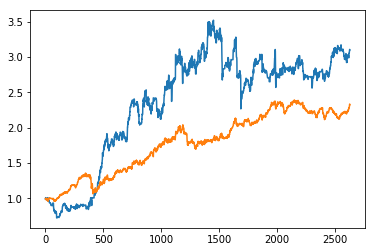

In [241]:
plt.plot(best_results["rmr_trend_follow_93"]["ret_with_fee"])
plt.plot(best_results["rmr_trend_follow_73"]["ret_with_fee"])

In [242]:
del best_results["markowitz40_118"]
del best_results["rmr_trend_follow_3_top3_91"]
del best_results["rmr_trend_follow_93"]
del best_results["eg_98"]
del best_results["eg_top3_1_96"]
del best_results["eg_top3_0_1_96"]
del best_results["rmr_2_87"]
del best_results["markowitz20_117"]
del best_results["ons_top1_100"]
del best_results["ons_top2_100"]
del best_results["ons_top3_100"]
del best_results["ons_top3_shorts_neutrl_100"]

In [243]:
best_results.keys()

dict_keys(['markowitz30_117', 'markowitz40_117', 'bmar1_3_top2_79', 'bmar1_3_top5_79', 'trend_follow_6_113', 'anticor_3_84', 'anticor_7_84', 'cfr_ogd3_107', 'cfr_ogd3_3_3_107', 'cfr_ons3_3_3_107', 'bmar1_3_85', 'bmar1_5_85', 'bmar2_85', 'rmr_trend_follow_95', 'rmr_trend_follow_2_95', 'rmr_trend_follow_3_91', 'arma_3_104', 'ons_100', 'markowitz_114', 'bollinger_10_110', 'bollinger_20_110', 'bollinger_30_110', 'crp_121', 'arma_108', 'eg_top3_shorts_0_1_96', 'eg_top3_shorts_1_96', 'sspo_7_109', 'arma_3_105', 'min_variance30_119', 'min_variance40_119', 'rmr_trend_follow_73'])

In [244]:
len(best_results)

31

In [245]:
df_prices = df_close_hour_8.iloc[-ticks_number:]
df_prices.drop("Unnamed: 0", axis=1, inplace=True)
df_prices.reset_index(drop=True, inplace=True)

In [246]:
df_prices.columns

Index(['FEES', 'PLZL', 'LKOH', 'ROSN', 'GMKN', 'POLY', 'MAGN', 'RSTI', 'MGNT',
       'ALRS', 'MSNG', 'NVTK', 'MVID', 'HYDR', 'RTKM', 'MTLR', 'VTBR', 'PHOR',
       'CHMF', 'AFLT', 'AFKS', 'SNGS', 'MTSS', 'RASP', 'MFON', 'NLMK', 'TATN',
       'SBER', 'GAZP', 'SIBN', 'MOEX', 'IRAO'],
      dtype='object')

In [247]:
dates_close_hour_8 = df_close_hour_8["Unnamed: 0"]

In [300]:
dates_close_hour_8.shape

(2681,)

In [249]:
trend_follow_73_ret_no_fee = np.cumsum(np.array(results["trend_follow_73"]["returns_no_fee"]) - 1) + 1

In [250]:
results["trend_follow_73"].keys()

dict_keys(['returns_no_fee', 'returns_with_fee', 'turnover', 'weights', 'epochs', 'config'])

In [251]:
epochs = results["trend_follow_73"]["epochs"]

In [252]:
df_close_hour_8["FEES"].values

array([0.08931, 0.08903, 0.08905, ..., 0.16478, 0.1654 , 0.16632])

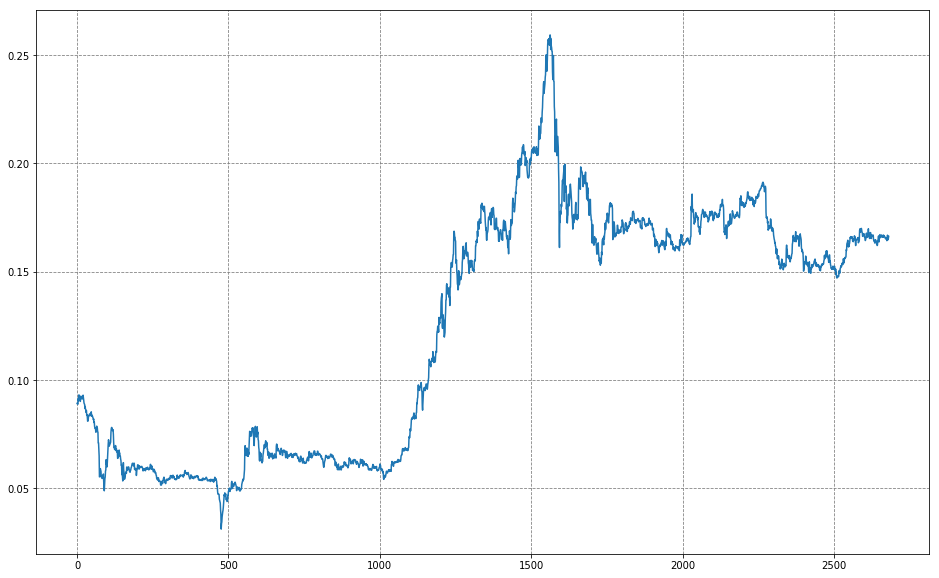

In [253]:
plt.figure(figsize=(16, 10))
plt.plot(df_close_hour_8["FEES"].values)
plt.grid(color='gray', linestyle='dashed')
plt.show()

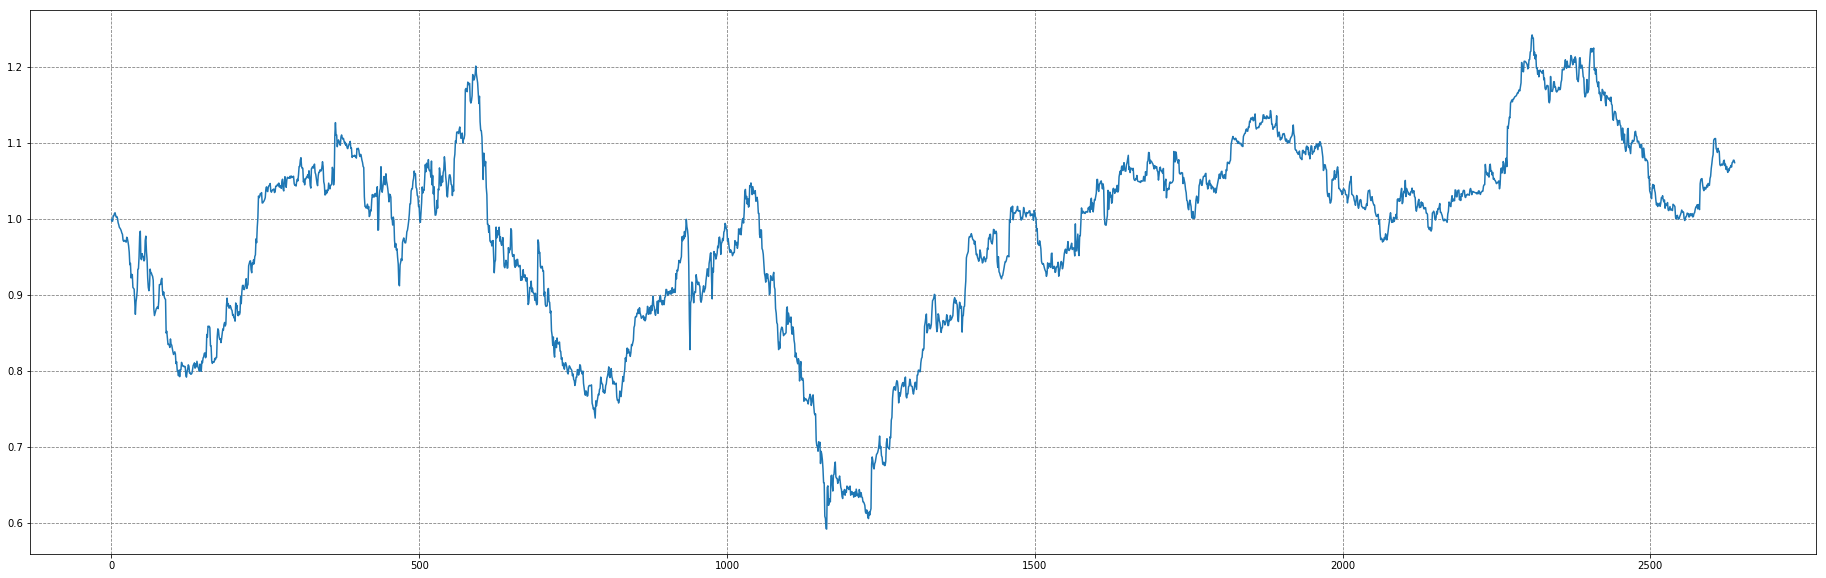

In [254]:
plt.figure(figsize=(32, 10))
plt.plot(trend_follow_73_ret_no_fee)
plt.grid(color='gray', linestyle='dashed')
plt.show()

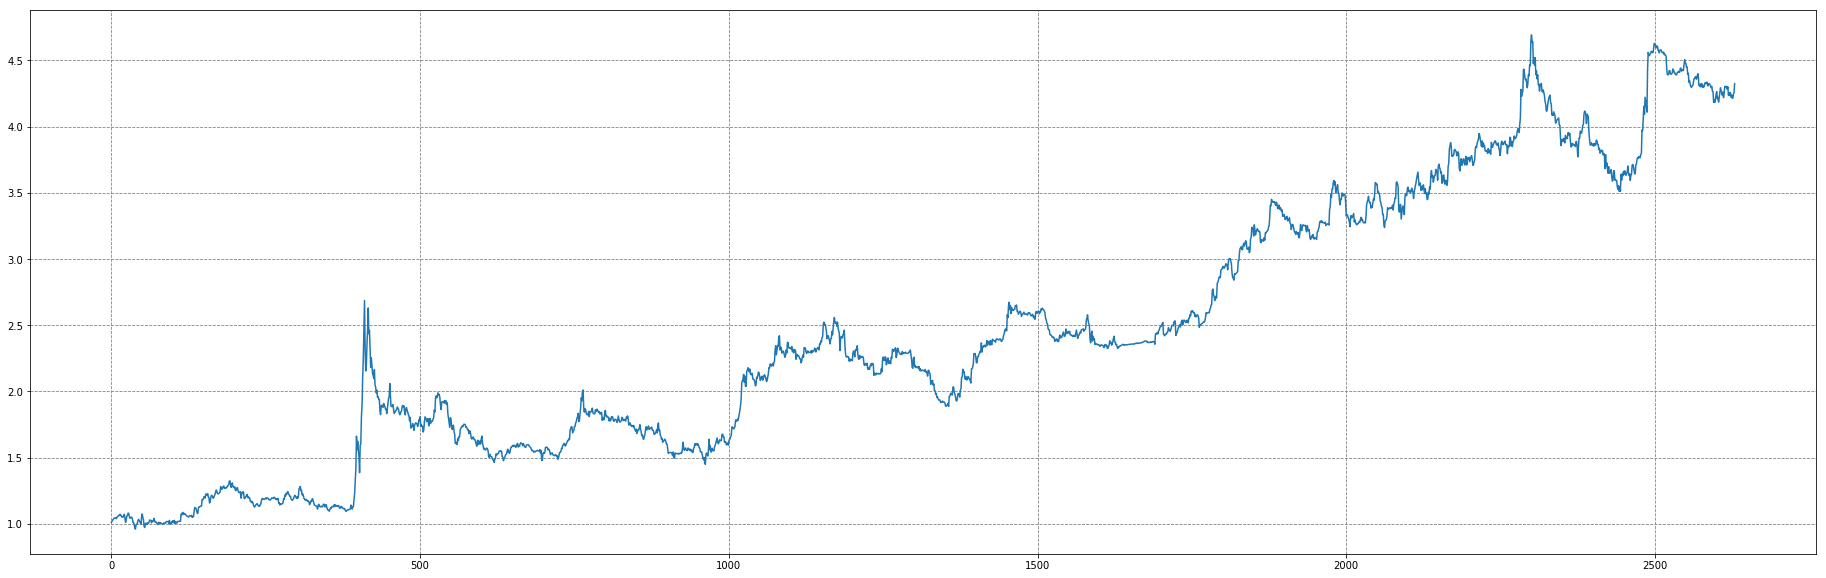

In [255]:
plt.figure(figsize=(32, 10))
plt.plot(best_results["trend_follow_6_113"]["ret_no_fee"])
plt.grid(color='gray', linestyle='dashed')
plt.show()

In [256]:
best_results["trend_follow_6_113"]["ret_with_fee"].shape

(2630,)

In [257]:
best_results["cfr_ogd3_107"]["weights"].shape

(2630, 30)

In [258]:
best_results["markowitz40_117"]["ret_with_fee"].shape

(2630,)

In [259]:
best_results["markowitz40_117"]["weights"].shape

(2630, 30)

In [290]:
def make_combined_df(df_prices, best_results):
    df_cols = {}
    for agent_name, res in best_results.items():
        df_cols[agent_name] = res["ret_with_fee"]
        
        for i, instr in enumerate(res["instruments_list"]):
            df_cols[agent_name + "_" + instr] = res["weights"][:, i]
    
    df_strat = pd.DataFrame(df_cols)
    df = pd.concat([df_prices, df_strat], axis=1)
    return df

In [291]:
len(list(best_results.keys()))

31

In [292]:
len(results["bmar1_3_85"]["config"]['instruments_list'])

30

In [293]:
json.dumps(list(best_results.keys()))

'["markowitz30_117", "markowitz40_117", "bmar1_3_top2_79", "bmar1_3_top5_79", "trend_follow_6_113", "anticor_3_84", "anticor_7_84", "cfr_ogd3_107", "cfr_ogd3_3_3_107", "cfr_ons3_3_3_107", "bmar1_3_85", "bmar1_5_85", "bmar2_85", "rmr_trend_follow_95", "rmr_trend_follow_2_95", "rmr_trend_follow_3_91", "arma_3_104", "ons_100", "markowitz_114", "bollinger_10_110", "bollinger_20_110", "bollinger_30_110", "crp_121", "arma_108", "eg_top3_shorts_0_1_96", "eg_top3_shorts_1_96", "sspo_7_109", "arma_3_105", "min_variance30_119", "min_variance40_119", "rmr_trend_follow_73"]'

In [294]:
df_combined = make_combined_df(df_prices, best_results)

In [295]:
df_combined.shape

(2630, 965)

In [296]:
dates = df_close_hour_8.iloc[-ticks_number:]["Unnamed: 0"].values

In [297]:
df_combined.index = dates

In [320]:
strategies_weights_dict = {}
for s in strategies:
    columns = [s + "_" + x for x in companies]
    strategies_weights_dict[s] = df_combined.loc[:, columns].fillna(0)

In [325]:
strategies_weights_dict["rmr_trend_follow_73"]

,rmr_trend_follow_73_FEES,rmr_trend_follow_73_PLZL,rmr_trend_follow_73_LKOH,rmr_trend_follow_73_ROSN,rmr_trend_follow_73_GMKN,rmr_trend_follow_73_POLY,rmr_trend_follow_73_MAGN,rmr_trend_follow_73_RSTI,rmr_trend_follow_73_MGNT,rmr_trend_follow_73_ALRS,...,rmr_trend_follow_73_MTSS,rmr_trend_follow_73_RASP,rmr_trend_follow_73_MFON,rmr_trend_follow_73_NLMK,rmr_trend_follow_73_TATN,rmr_trend_follow_73_SBER,rmr_trend_follow_73_GAZP,rmr_trend_follow_73_SIBN,rmr_trend_follow_73_MOEX,rmr_trend_follow_73_IRAO
2014-02-14 10:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.113590,0.175562,...,0.174440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.157109,0.000000
2014-02-14 18:00:00,0.000000,0.000000,0.000000,0.000000,-0.182038,0.000000,0.0,-0.136430,0.000000,0.248837,...,0.000000,0.000000,0.104980,0.000000,0.000000,0.000000,0.000000,0.000000,-0.181532,0.000000
2014-02-17 10:00:00,0.151028,0.000000,0.000000,0.000000,0.000000,-0.313328,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.089203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140816
2014-02-17 18:00:00,0.146916,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.157075,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.123621,0.000000,-0.193452,0.000000
2014-02-18 10:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.204844,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-02-18 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.172760,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167144,0.160095,-0.154462
2014-02-19 10:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.146664,0.0,0.000000,0.000000,0.000000,...,0.000000,0.192910,-0.156695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-02-19 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.236110,0.0,0.000000,0.000000,-0.104008,...,0.000000,0.273074,0.000000,0.065368,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-02-20 10:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.181363,0.0,0.000000,0.000000,-0.176934,...,0.000000,0.213708,0.000000,0.000000,0.000000,0.000000,0.154444,-0.141703,0.000000,0.000000
2014-02-20 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.120475,0.000000,...,0.162428,0.209402,0.000000,0.000000,0.000000,0.000000,0.000000,-0.248358,-0.131167,0.000000


In [ ]:
a = []
b = [1, 2]

In [ ]:
a+ b

In [323]:
for x, val in strategies_weights_dict.items():
    print(x, (val < 0).sum().sum())

markowitz30_117 0
markowitz40_117 0
min_variance30_119 0
min_variance40_119 0
sspo_7_109 0
trend_follow_6_113 0
rmr_trend_follow_3_91 0
bmar1_3_top2_79 5234
bmar1_3_top5_79 13002
bollinger_10_110 0
bollinger_20_110 0
bollinger_30_110 0
rmr_trend_follow_95 0
rmr_trend_follow_2_95 0
anticor_3_84 0
anticor_7_84 0
arma_3_104 0
markowitz_114 0
eg_top3_shorts_0_1_96 0
eg_top3_shorts_1_96 0
arma_3_105 0
cfr_ogd3_107 0
cfr_ogd3_3_3_107 0
cfr_ons3_3_3_107 0
bmar1_3_85 0
bmar1_5_85 0
bmar2_85 0
rmr_trend_follow_73 5531
ons_100 0
arma_108 0


## Look ahead check:

In [305]:
fees = df_combined["FEES"].values
fees /= fees[0]
fees_crp = df_combined["crp_121"].values
fees_crp /= fees_crp[0]

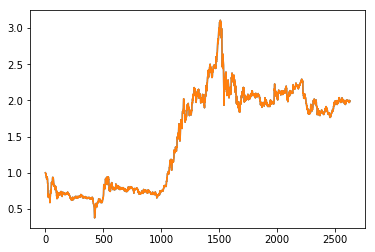

In [306]:
plt.plot(fees)
plt.plot(fees_crp)

In [314]:
df_combined.loc[:, ["rmr_trend_follow_73_MTSS", "rmr_trend_follow_73_MT"]].fillna(0)

,rmr_trend_follow_73_MTSS,rmr_trend_follow_73_MT
2014-02-14 10:00:00,0.174440,0.0
2014-02-14 18:00:00,0.000000,0.0
2014-02-17 10:00:00,0.000000,0.0
2014-02-17 18:00:00,0.000000,0.0
2014-02-18 10:00:00,0.000000,0.0
2014-02-18 18:00:00,0.000000,0.0
2014-02-19 10:00:00,0.000000,0.0
2014-02-19 18:00:00,0.000000,0.0
2014-02-20 10:00:00,0.000000,0.0
2014-02-20 18:00:00,0.162428,0.0


In [309]:
df_combined.to_csv("../data/combined_hour_8_with_weights.csv")

In [335]:
#df_combined.to_csv("../data/combined_hour_8_with_fees_crp.csv")

In [133]:
df_combined_read = pd.read_csv("../data/combined_hour_8_2.csv")

In [134]:
df_combined_read.shape

(2630, 64)

In [170]:
df_combined_read["FEES"].values / df_combined_read["FEES"].values[0]

array([1.        , 0.9930464 , 0.98909004, ..., 1.9755425 , 1.98297566,
       1.99400551])

In [173]:
np.array(results["crp_121"]["returns_no_fee"]).cumprod() / np.array(results["crp_121"]["returns_no_fee"])[0]

array([1.        , 0.99241932, 0.9998917 , ..., 1.78449209, 1.79120641,
       1.80116959])

In [102]:
def convert_to_panel_combined(df, companies, start_ts=None, end_ts=None):
    df.index = pd.to_datetime(df["Unnamed: 0"])
    all_dates = sorted(set(df["Unnamed: 0"]))
    all_dates = np.array(all_dates)
    if start_ts is not None:
        start = datetime.datetime.fromtimestamp(start_ts).strftime("%Y-%m-%d %H-%M-%S")
        all_dates = all_dates[all_dates > start]
    if end_ts is not None:
        end = datetime.datetime.fromtimestamp(end_ts).strftime("%Y-%m-%d %H-%M-%S")
        all_dates = all_dates[all_dates < end]
    time_index = pd.to_datetime(all_dates)
    
    panel = pd.Panel(items=["close"], major_axis=companies, minor_axis=time_index, dtype=np.float32)
    for company in companies:
        panel.loc["close", company, time_index] = df.loc[time_index, company]
    return panel

In [103]:
print([0 for i in range(30)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [138]:
coins_list = [
            "FEES", "PLZL", "LKOH", "ROSN", "GMKN", "POLY", 
            "MAGN", "RSTI", "MGNT", "ALRS", "MSNG", "NVTK", 
            "MVID", "HYDR", "RTKM", "VTBR", "PHOR", 
            "CHMF", "AFLT", "SNGS", "MTSS", "RASP", 
            "MFON", "NLMK", "TATN", "SBER", "GAZP", 
            "SIBN", "MOEX", "IRAO",
            "markowitz30_117", "markowitz40_117", "min_variance30_119", "min_variance40_119", "sspo_7_109", 
            "trend_follow_6_113", "rmr_trend_follow_3_91", "bmar1_3_top2_79", "bmar1_3_top5_79", "bollinger_10_110", 
            "bollinger_20_110", "bollinger_30_110", "rmr_trend_follow_95", "rmr_trend_follow_2_95", "anticor_3_84", 
            "anticor_7_84", "arma_3_104", "markowitz_114", "eg_top3_shorts_0_1_96", "eg_top3_shorts_1_96", "arma_3_105", 
            "cfr_ogd3_107", "cfr_ogd3_3_3_107", "cfr_ons3_3_3_107", "bmar1_3_85", "bmar1_5_85", "bmar2_85", 
            "rmr_trend_follow_73", "ons_100", "arma_108"
        ]

In [105]:
results["rmr_trend_follow_95"]["config"]

{'instruments_list': ['SBER',
  'GAZP',
  'LKOH',
  'GMKN',
  'MGNT',
  'ROSN',
  'VTBR',
  'ALRS',
  'NVTK',
  'MOEX',
  'CHMF',
  'TATN',
  'SNGS',
  'MTSS',
  'AFLT',
  'NLMK',
  'HYDR',
  'MAGN',
  'FEES',
  'IRAO',
  'RTKM',
  'AFKS',
  'RSTI'],
 'exchange': 'moex_close_2014_2019_hour_8',
 'candles_res': 'period',
 'step': 1,
 'epsilon': 10,
 'window': 3,
 'price_relatives_flag': True,
 'down_trend_threshold': 13,
 'window_long': 40,
 'window_short': 20,
 'agent_class': 'rmr_trend_follow',
 'agent_name': 'rmr_trend_follow',
 'price_label': 'close',
 'use_risk_free': False,
 'short_flag': False,
 'neutralize_flag': False,
 'projection_method': 'simplex',
 'top_amount': 1}

In [106]:
results["rmr_trend_follow_95"]["config"]

{'instruments_list': ['SBER',
  'GAZP',
  'LKOH',
  'GMKN',
  'MGNT',
  'ROSN',
  'VTBR',
  'ALRS',
  'NVTK',
  'MOEX',
  'CHMF',
  'TATN',
  'SNGS',
  'MTSS',
  'AFLT',
  'NLMK',
  'HYDR',
  'MAGN',
  'FEES',
  'IRAO',
  'RTKM',
  'AFKS',
  'RSTI'],
 'exchange': 'moex_close_2014_2019_hour_8',
 'candles_res': 'period',
 'step': 1,
 'epsilon': 10,
 'window': 3,
 'price_relatives_flag': True,
 'down_trend_threshold': 13,
 'window_long': 40,
 'window_short': 20,
 'agent_class': 'rmr_trend_follow',
 'agent_name': 'rmr_trend_follow',
 'price_label': 'close',
 'use_risk_free': False,
 'short_flag': False,
 'neutralize_flag': False,
 'projection_method': 'simplex',
 'top_amount': 1}

In [107]:
df_combined_read

,Unnamed: 0,FEES,PLZL,LKOH,ROSN,GMKN,POLY,MAGN,RSTI,MGNT,...,bollinger_30_110,crp_121,arma_108,eg_top3_shorts_0_1_96,eg_top3_shorts_1_96,sspo_7_109,arma_3_105,min_variance30_119,min_variance40_119,rmr_trend_follow_73
0,2014-02-14 10:00:00,0.08341,735.4,2033.5,245.50,5626.0,368.06,6.849,0.7240,8469.9,...,0.997022,0.998922,0.987489,1.007724,1.007814,1.000000,0.987489,1.001810,1.001162,0.998794
1,2014-02-14 18:00:00,0.08283,746.0,2036.6,247.18,5673.0,383.75,6.873,0.7270,8500.0,...,1.012152,0.991976,1.001248,1.012132,1.012360,1.013333,1.001248,1.007578,1.007057,1.001729
2,2014-02-17 10:00:00,0.08250,744.9,2047.1,248.32,5717.0,385.99,6.891,0.7280,8569.9,...,1.008464,0.988024,1.007270,1.019048,1.019313,1.008688,1.007270,1.010355,1.008887,0.999446
3,2014-02-17 18:00:00,0.08170,765.0,2043.9,249.94,5757.0,398.42,6.907,0.7300,8589.5,...,1.007741,0.978443,1.004596,1.023860,1.024202,0.998907,1.004596,1.012329,1.011745,0.996488
4,2014-02-18 10:00:00,0.08210,773.0,2049.9,249.86,5789.0,397.00,6.934,0.7370,8632.2,...,1.012919,0.983234,1.008912,1.028329,1.028712,1.003797,1.008912,1.016177,1.014427,0.997319
5,2014-02-18 18:00:00,0.08045,781.3,2040.0,250.02,5814.0,388.00,7.046,0.7320,8605.0,...,1.018484,0.963473,1.005688,1.022586,1.023352,1.004311,1.005688,1.014462,1.012264,0.995854
6,2014-02-19 10:00:00,0.08065,780.0,2039.3,250.13,5812.0,392.00,6.960,0.7320,8577.2,...,1.018340,0.965868,1.015452,1.018542,1.019461,1.006205,1.015452,1.014096,1.011414,0.992628
7,2014-02-19 18:00:00,0.07862,760.7,2025.1,247.70,5824.0,393.17,6.826,0.7260,8661.7,...,1.021395,0.941557,0.987977,1.008342,1.009781,0.978980,0.987977,1.010367,1.010690,0.982674
8,2014-02-20 10:00:00,0.07816,750.4,2010.1,245.32,5781.0,390.11,6.762,0.7250,8570.0,...,1.003375,0.936048,0.980303,0.998702,1.000240,0.958100,0.980303,1.002099,1.004308,0.978582
9,2014-02-20 18:00:00,0.07765,755.0,2042.9,246.54,5850.0,381.21,6.739,0.7220,8695.1,...,1.003955,0.929940,1.013827,1.006004,1.007790,0.991440,1.013827,1.010372,1.009662,0.986511


In [110]:
panel = convert_to_panel_combined(df_combined_read, coins_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


In [56]:
df_for_ubah = panel["close"].T[panel["close"].T.index > "2018-10-31 10:00:00"]

In [315]:
all_assets = [
    "FEES", "PLZL", "LKOH", "ROSN", "GMKN", "POLY", 
    "MAGN", "RSTI", "MGNT", "ALRS", "MSNG", "NVTK", 
    "MVID", "HYDR", "RTKM", "VTBR", "PHOR", 
    "CHMF", "AFLT", "SNGS", "MTSS", "RASP", 
    "MFON", "NLMK", "TATN", "SBER", "GAZP", 
    "SIBN", "MOEX", "IRAO",
    "markowitz30_117", "markowitz40_117", "min_variance30_119", "min_variance40_119", "sspo_7_109", 
    "trend_follow_6_113", "rmr_trend_follow_3_91", "bmar1_3_top2_79", "bmar1_3_top5_79", "bollinger_10_110", 
    "bollinger_20_110", "bollinger_30_110", "rmr_trend_follow_95", "rmr_trend_follow_2_95", "anticor_3_84", 
    "anticor_7_84", "arma_3_104", "markowitz_114", "eg_top3_shorts_0_1_96", "eg_top3_shorts_1_96", "arma_3_105", 
    "cfr_ogd3_107", "cfr_ogd3_3_3_107", "cfr_ons3_3_3_107", "bmar1_3_85", "bmar1_5_85", "bmar2_85", 
    "rmr_trend_follow_73", "ons_100", "arma_108"
]
companies = [
    "FEES", "PLZL", "LKOH", "ROSN", "GMKN", "POLY", 
    "MAGN", "RSTI", "MGNT", "ALRS", "MSNG", "NVTK", 
    "MVID", "HYDR", "RTKM", "VTBR", "PHOR", 
    "CHMF", "AFLT", "SNGS", "MTSS", "RASP", 
    "MFON", "NLMK", "TATN", "SBER", "GAZP", 
    "SIBN", "MOEX", "IRAO"
]
strategies = [
    "markowitz30_117", "markowitz40_117", "min_variance30_119", "min_variance40_119", "sspo_7_109", 
    "trend_follow_6_113", "rmr_trend_follow_3_91", "bmar1_3_top2_79", "bmar1_3_top5_79", "bollinger_10_110", 
    "bollinger_20_110", "bollinger_30_110", "rmr_trend_follow_95", "rmr_trend_follow_2_95", "anticor_3_84", 
    "anticor_7_84", "arma_3_104", "markowitz_114", "eg_top3_shorts_0_1_96", "eg_top3_shorts_1_96", "arma_3_105", 
    "cfr_ogd3_107", "cfr_ogd3_3_3_107", "cfr_ons3_3_3_107", "bmar1_3_85", "bmar1_5_85", "bmar2_85", 
    "rmr_trend_follow_73", "ons_100", "arma_108"
]

In [113]:
def compute_ubah(df):
    values = df.values
    companies_returns = values[:] / values[0]
    ubah = companies_returns.mean(1)
    return ubah


def compute_crp(df):
    values = df.values
    companies_returns = values[1:] / values[:-1]
    crp = np.cumprod(companies_returns.mean(1))
    return crp

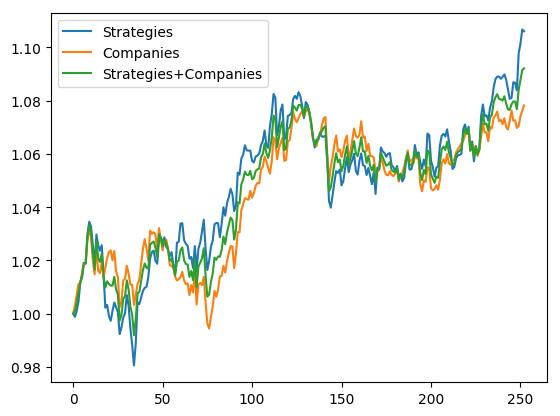

In [392]:
plt.plot(compute_ubah(df_for_ubah[strategies]), label="Strategies")
plt.plot(compute_ubah(df_for_ubah[companies]), label="Companies")
plt.plot(compute_ubah(df_for_ubah[all_assets]), label="Strategies+Companies")
plt.legend()

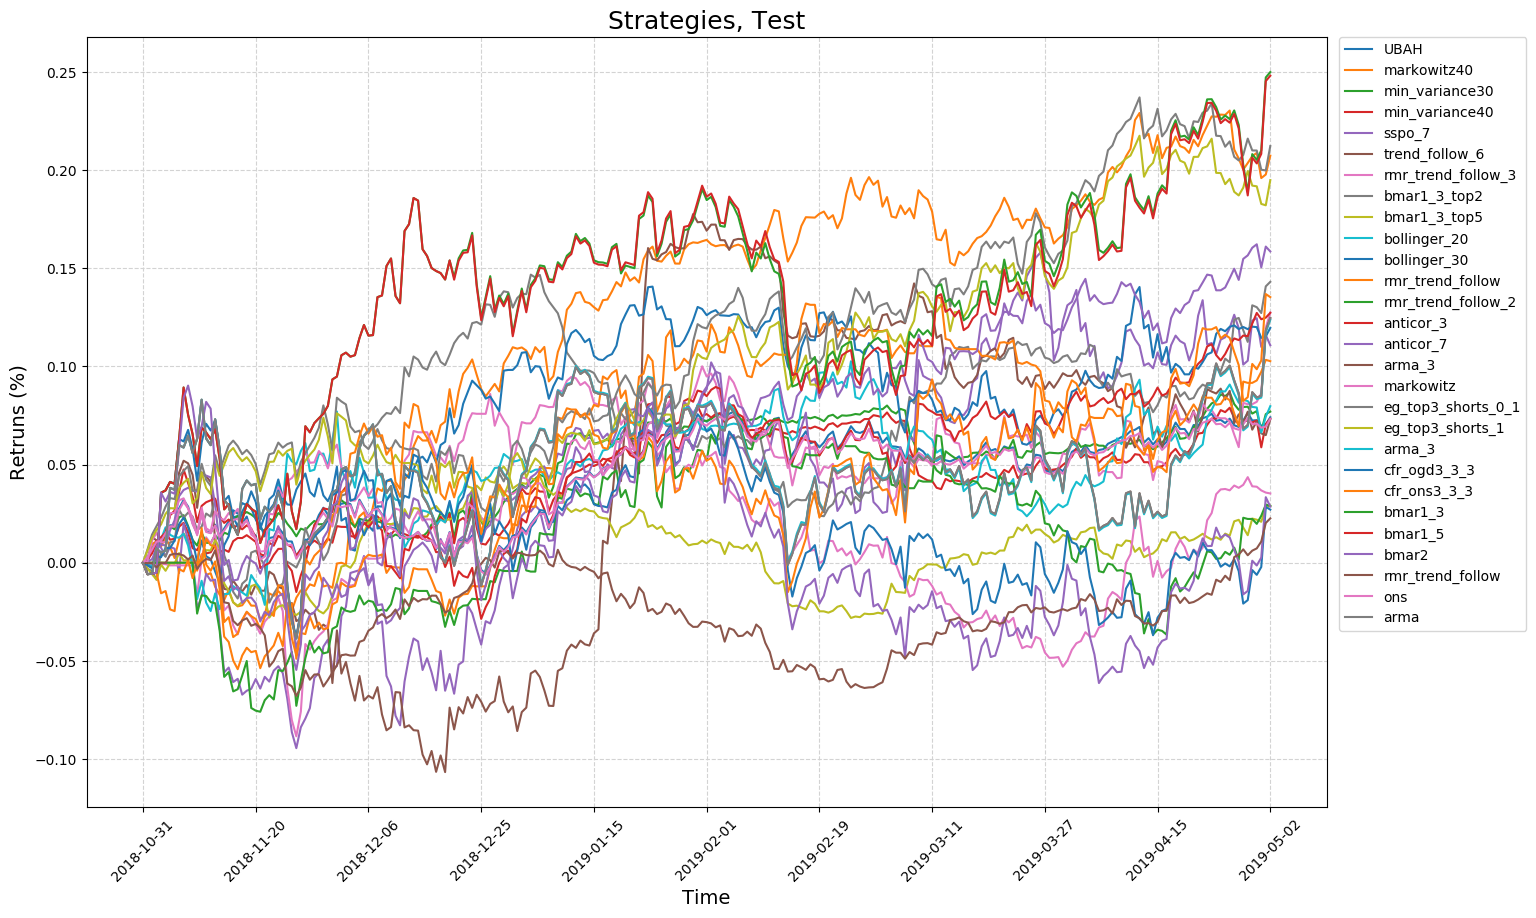

In [127]:
df_close = panel["close"].T
start = "2018-10-31 10:00:00"
end = "2019-05-03 10:00:00"
df_for_ubah = df_close[(df_close.index > start) & (df_close.index < end)]

strategy_prices = df_for_ubah[strategies].values
strategy_returns_ubah = strategy_prices / strategy_prices[0]

dates = df_for_ubah[strategies].index

indices = list(range(len(compute_ubah(df_for_ubah[strategies]))))

plt.figure(figsize=(16, 10))
#plt.plot(indices, compute_ubah(df_for_ubah[strategies]), label="Strategies")
plt.plot(indices, compute_ubah(df_for_ubah[companies]) - 1, label="UBAH")
#plt.plot(indices, compute_ubah(df_for_ubah[all_assets]), label="Strategies+Companies")
for i, strat in enumerate(strategies):
    x = strategy_returns_ubah[:, i]
    if x[-1] > 1.01:
        plt.plot(indices, x - 1, label="_".join(strat.split("_")[:-1]))

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.title("Strategies, Test", size=18)
plt.xlabel("Time", size=14)
plt.ylabel("Retruns (%)", size=14)
plt.grid(color='lightgray', linestyle='dashed')
dates_str = [str(x)[:10] for x in dates]
step = int(len(dates_str) / 10)
plt.xticks(indices[::step], dates_str[::step], rotation=45)
plt.show()